# Description

- This is an analysis notebook

## Features

## todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
from log_parser import process_file


# parameters

In [4]:
# _fname = "../replays/local.log"
# _fname = "../replays/log12-multi.log"
_fname = "../replays/log14-noclose.log"
# _fname = "../replays/selftrade-rev.log"
_time_step = 100
_max_time = 200000
_num_close_turns = 30
_symbols = ["BANANAS", "PEARLS"]
_products = ["BANANAS", "PEARLS"]

print("_fname", _fname)


_fname ../replays/log14-noclose.log


# pre processing

In [5]:
# load data from file

obj = process_file(_fname, start_sep="__game_state_start", end_sep="__game_state_end")

raw_df = pd.DataFrame(obj)

listings = pd.DataFrame(raw_df["listings"][0])
# products = set(listings.T["product"])
raw_df = raw_df.drop("listings", axis=1)
raw_df = raw_df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_df["time"])
print("num missing_times", len(missing_times))
print("missing_times", missing_times)


Reading from input file ../replays/log14-noclose.log
num missing_times 4
missing_times {28000, 24000, 100700, 53200}


In [ ]:
# load order info from file
obj = process_file(_fname, start_sep="__turn_end_start", end_sep="__turn_end_end")
raw_records = pd.DataFrame(obj)

### add turns

In [6]:
# add turns (vs time)

all_times = raw_df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
raw_df["turn"] = raw_df["time"].map(time2turn_map)

raw_df.index = raw_df["turn"]

### book_tops

#### modify raw_df["book"] to be all ints

In [7]:
# modify raw_df["book"] to be all ints
raw_df["book"] = raw_df["book"].apply(lambda x: {
    sym: {
        typ: {
            int(k) : v for k, v in orders.items()
        }
        for typ, orders in all_orders.items()
    }
    for sym, all_orders in x.items()
})

In [8]:
book_data = []
book_cols = []

cmp = lambda k : tuple([int(k[0]), int(k[1])])

for sym in _symbols:
    ### buys
    col = raw_df["book"].apply(lambda x: x[sym])
    # convert dicts into int -> int
    col = col.apply(lambda x : [(int(k), v) for k, v in x["buy_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=True))
    col = col.apply(lambda x : x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_buy"]
    
    
    ### sells
    col = raw_df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x : [(int(k), v) for k, v in x["sell_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=False))
    col = col.apply(lambda x: x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_sell"]
    
    
book_tops = pd.concat(book_data, axis=1)
book_tops.columns = book_cols

# all book tops
for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    
    print("missing mids", sym, list(book_tops.index[book_tops[f"{sym}_mid"].isna()]))
    
    book_tops[f"{sym}_mid"] = book_tops[f"{sym}_mid"].bfill()
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = raw_df["time"]



missing mids BANANAS []
missing mids PEARLS []


In [9]:
num_data_dropna = len(book_tops.dropna())
num_data = len(book_tops)

print(f"Orig count: {num_data}")
print(f"Remaining count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 1996
Remaining count: 1996
nan count: 0


In [10]:
### flatt

In [11]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

### func - flatten_trades() + mark my trades

In [12]:
def flatten_trades(df, col, is_me):
    # get market trades

    data = []
    for index, row  in df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    # report self trades
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

### dup trade filtering -> market_trades, my_trades, trade_df

In [13]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    raw_df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")

market_trades = market_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])
my_trades = my_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])


### old filter methods
# # filter market trades (only keep those where order_time = fill_time)
# market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# # filter my_trades (only keep those where fill_time = order_time + 100)
# my_trades = my_trades[my_trades["time"] <= my_trades["order_time"] + _time_step]
### end of old filter methods

trade_df = pd.concat([market_trades, my_trades])
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
# trade_df = trade_df.drop(["order_time", "buyer", "seller"], axis=1)

my_trades = trade_df[trade_df["is_me"]]
market_trades = trade_df[~trade_df["is_me"]]


### volume summary

In [14]:
for sym in _symbols:
    print(sym)
    
    my_sym_trades = my_trades[my_trades["symbol"] == sym]
    my_volume = my_sym_trades["quantity"].abs().sum()
    market_sym_trades = market_trades[market_trades["symbol"] == sym]
    market_volume = market_sym_trades["quantity"].abs().sum()
    
    my_vol_perc = my_volume / (my_volume + market_volume) * 100
    
    print("[THEM]\t count:", len(market_sym_trades), "\tvolume:", market_volume)
    print("[MY]\t count:", len(my_sym_trades), "\tvolume:", my_volume)
    print(f"[MY]\t vol%: {round(my_vol_perc, 2)}%")

BANANAS
[THEM]	 count: 372 	volume: 780
[MY]	 count: 325 	volume: 844
[MY]	 vol%: 51.97%
PEARLS
[THEM]	 count: 319 	volume: 527
[MY]	 count: 343 	volume: 547
[MY]	 vol%: 50.93%


### my_position validation

In [15]:
# get my_positions
my_positions = pd.DataFrame(list(raw_df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = raw_df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
pos_data = []
cur_positions = { prod: 0 for prod in _products }
cur_positions["cash"] = 0
fixed_positions = copy.deepcopy(cur_positions)

cur_time = turn2time_map[0]

def record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data):
    global my_positions
    
    # copy orig pos
    pos_data += [copy.deepcopy(cur_positions)]
    
    # fix positions if necessary
    cur_turn = time2turn_map[cur_time]
        
    # init fixed_positions for this turn
    for prod in _products:
        diff = my_positions[prod][cur_turn] - fixed_positions[prod]
        price = book_tops[f"{prod}_mid"][cur_turn]
        
        if diff != 0:
            print(f"[Fixed trade] Turn: {cur_turn}, time: {cur_time}, {prod} {diff} @ {price}")
            
        fixed_positions[prod] += diff
        fixed_positions["cash"] += -1 * diff * price

    # copy fixed pos
    fixed_pos_data += [copy.deepcopy(fixed_positions)]
    
    
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
        cur_time = turn2time_map[len(pos_data)]
        
    prod = listings[row["symbol"]]["product"]
    # update cur
    cur_positions["cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]
    
    # update fixed
    fixed_positions["cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
    cur_time = turn2time_map[len(pos_data)]

record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(pos_data).sort_index(axis=1)

# add to my_positions
my_positions["cash"] = pos_df["cash"]
my_positions = my_positions.sort_index(axis=1)


try:
    for prod in ["cash", *_products]:
        bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
        if len(bad_inds) > 0:
            print("true pos")
            display(my_positions.loc[bad_inds])
            print("calculated pos")
            display(pos_df.loc[bad_inds])
            assert False, f"Failed check for product: `{prod}`"
except AssertionError:
    traceback.print_exc()
    
    print("Using fixed_pos_df['cash']")
    fixed_pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)
    my_positions["cash"] = fixed_pos_df["cash"]

[Fixed trade] Turn: 1479, time: 148300, PEARLS -2.0 @ 10003.0
true pos


,BANANAS,PEARLS,cash,time,turn
1479,-17.0,-1.0,75400.0,148300,1479
1480,-20.0,-1.0,90199.0,148400,1480
1481,-20.0,-1.0,90199.0,148500,1481
1482,-20.0,-1.0,90199.0,148600,1482
1483,-20.0,-1.0,90199.0,148700,1483
...,...,...,...,...,...
1991,-4.0,-10.0,102211.0,199500,1991
1992,-4.0,-10.0,102211.0,199600,1992
1993,-4.0,-10.0,102211.0,199700,1993
1994,-4.0,-9.0,92209.0,199800,1994


calculated pos


,BANANAS,PEARLS,cash
1479,-17,1,75400.0
1480,-20,1,90199.0
1481,-20,1,90199.0
1482,-20,1,90199.0
1483,-20,1,90199.0
...,...,...,...
1991,-4,-8,102211.0
1992,-4,-8,102211.0
1993,-4,-8,102211.0
1994,-4,-7,92209.0


Using fixed_pos_df['cash']


Traceback (most recent call last):
  File "/var/folders/fv/6rc0c0r11hn6xpyhsr9z6rrc0000gn/T/ipykernel_26835/1603851576.py", line 85, in <module>
    assert False, f"Failed check for product: `{prod}`"
AssertionError: Failed check for product: `PEARLS`


### Construct postbook
- Want to see what the world looked like, after we submit our orders

In [16]:
f_buy = lambda x : sorted(list(x.items()), reverse=True)
f_sell = lambda x : sorted(list(x.items()), reverse=False)
f_my_buy = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=True)
f_my_sell = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=False)

book = pd.merge(raw_df[["book", "time"]], raw_records, on="time")

for sym in _symbols:
    book[f"{sym}_buys"] = book["book"].apply(lambda x : f_buy(x[sym]["buy_orders"]))
    book[f"{sym}_sells"] = book["book"].apply(lambda x : f_sell(x[sym]["sell_orders"]))
    book[f"{sym}_my_buys"] = book["my_orders"].apply(lambda x : f_my_buy(x[sym]["buy_orders"]))
    book[f"{sym}_my_sells"] = book["my_orders"].apply(lambda x : f_my_sell(x[sym]["sell_orders"]))

book = book.drop(["book", "my_orders"], axis=1)

NameError: name 'raw_records' is not defined

In [17]:
def get_book(sym, time):
    buys = book[book["time"] == time][f"{sym}_buys"].iloc[0]
    sells = book[book["time"] == time][f"{sym}_sells"].iloc[0]
    my_buys = book[book["time"] == time][f"{sym}_my_buys"].iloc[0]
    my_sells = book[book["time"] == time][f"{sym}_my_sells"].iloc[0]
    
    return buys, sells, my_buys, my_sells

def show_book(sym, 
              time, 
              xmin=None, 
              xmax=None,
              ymin=None, 
              ymax=None,
             ):
    buys, sells, my_buys, my_sells = get_book(sym, time)
    
    buys = buys
    sells = [(p, -q) for p, q in sells]
    my_buys = [(p, -q) for p, q in my_buys]
    my_sells = my_sells
    
    f1 = lambda x : [el[0] for el in x]
    f2 = lambda x : [el[1] for el in x]
    f = lambda x : zip(*x)
    
    print(buys)
    print(sells)
    print(my_buys)
    print(my_sells)
    
    
    
    
    if len(buys) > 0:
        plt.bar(*f(buys), color="green", label="market buy")
    if len(sells) > 0:
        plt.bar(*f(sells), color="red", label='market sell')
    
    if len(my_buys) > 0:
        plt.bar(*f(my_buys), color="blue", label="my buy")
    if len(my_sells) > 0:
        plt.bar(*f(my_sells), color="orange", label="my sell")
    
    plt.legend()
    plt.title(f"{sym} - Order book")
    
    # set xlim, ylim
    if xmin:
        plt.xlim(xmin=xmin)
    if xmax:
        plt.xlim(xmax=xmax)
    if ymin:
        plt.ylim(ymin=ymin)
    if ymax:
        plt.ylim(ymax=ymax)
    
    # draw horizontal line at 0 
    plt.axhline(y=0.0, color="black", linestyle='-')
    plt.show()
    
    
def show_book_simple(
        sym,
        time=0,
        ):
    show_book(
        sym, 
        time,
    )

In [18]:
interact(
    show_book_simple,
    sym=["BANANAS", "PEARLS"],
    time=(0, _max_time, _time_step),
)

interactive(children=(Dropdown(description='sym', options=('BANANAS', 'PEARLS'), value='BANANAS'), IntSlider(v…

<function __main__.show_book_simple(sym, time=0)>

# Analysis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

## General summary

### Estimate Fairs

In [19]:
# estimate fairs
mid_cols = [col for col in book_tops.columns if "_mid" in col]
fairs = book_tops[["time", *mid_cols]]
fairs.columns = fairs.columns.str.strip('_mid')

fairs

,time,BANANAS,PEARLS
turn,,,
0,0,4949.0,10001.5
1,100,4947.5,9999.0
2,200,4948.0,10000.0
3,300,4948.5,9997.0
4,400,4949.0,10001.0
...,...,...,...
1991,199500,4933.5,9997.0
1992,199600,4933.5,10000.0
1993,199700,4934.0,10003.0


### Estimate PNLs

In [20]:
# estimate pnl
pnls = my_positions["cash"]

for prod in _products:
    pnls = pnls + my_positions[prod] * fairs[prod]
    
my_positions["pnl"] = pnls

#### func -  plot_trades_and_book()

In [21]:
# plot trades
def plot_trades_and_book(
        sym, 
        trade_df, 
        book_df, 
        time_lb=float("-inf"), 
        time_ub=float("inf"), 
        span=21,
        show_mid=False,
        ):
    
    trade_df = trade_df[(time_lb <= trade_df["time"]) & (trade_df["time"] <= time_ub)]
    book_df = book_df[(time_lb <= book_df["time"]) & (book_df["time"] <= time_ub)]
    
    # filter for this symbol only
    plt_df = trade_df
    plt_df = plt_df[plt_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="orange", s=5)
    
    
    book_df = book_df
    
    bids = book_df[f"{sym}_best_buy"]
    asks = book_df[f"{sym}_best_sell"]
    mids = book_df[f"{sym}_mid"]
    smooth_bids = bids.ewm(span=span).mean()
    smooth_asks = asks.ewm(span=span).mean()
    smooth_mids = mids.ewm(span=span).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    times = book_df["time"]
    
    # plot book
    ax = axes[0]
    ax.plot(times, bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(times, asks, c="red", alpha=0.5, linewidth=0.5)
    if show_mid:
        ax.plot(times, mids, c="black", alpha=0.25, linewidth=0.5)
    plot_trades(ax)
    ax.set_title(f"Trades and book: {sym}")
    
    ax = axes[1]
    ax.plot(times, smooth_bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(times, smooth_asks, c="red", alpha=0.5, linewidth=0.5)
    if show_mid:
        ax.plot(times, smooth_mids, c="black", alpha=0.5, linewidth=0.5)
    ax.set_title(f"(smooth) Trades and book: {sym}")
    plot_trades(ax)

    plt.show()
    

### overall trade/book graph

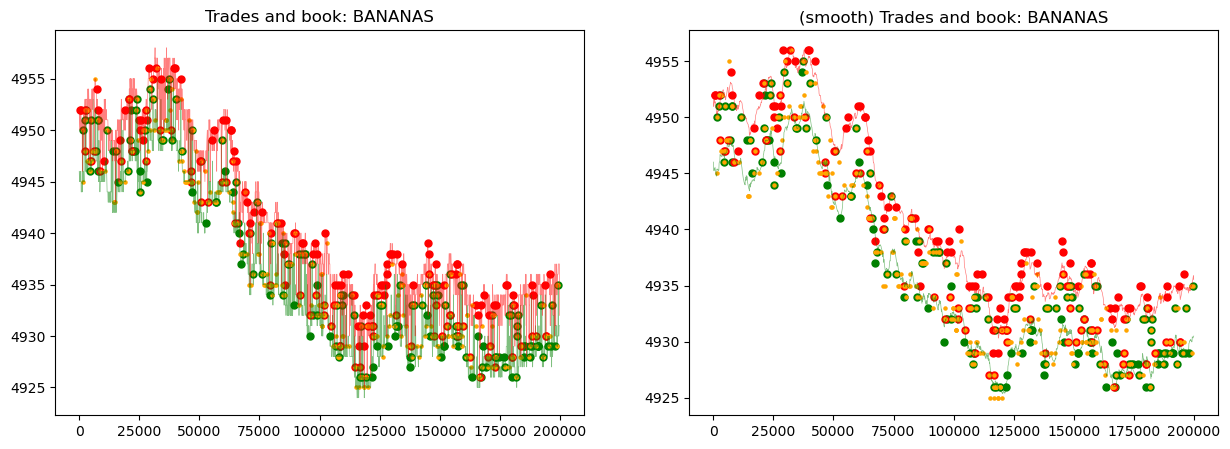

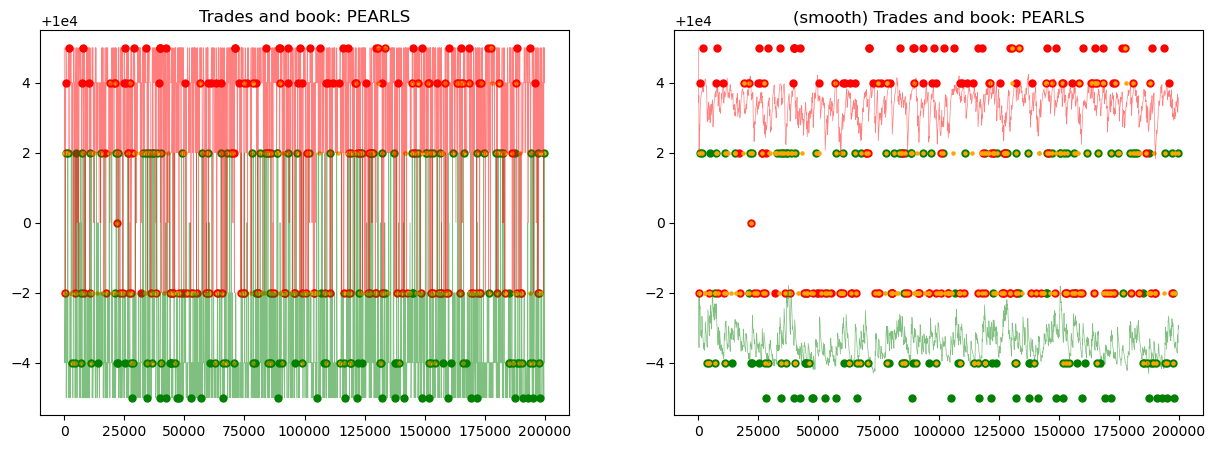

In [22]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21
)
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21
)


### PNL Graph

Text(0.5, 1.0, 'PNL')

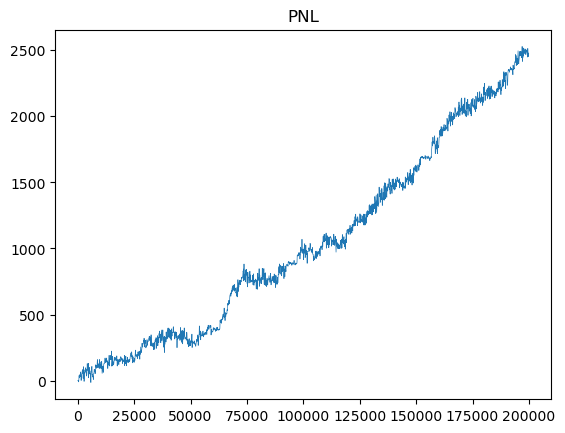

In [23]:
# pnl
plt.plot(my_positions["time"], my_positions["pnl"], linewidth=0.5)
plt.title("PNL")

### Positions Graph

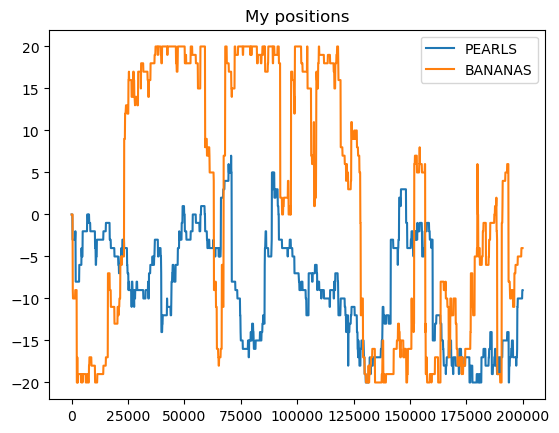

In [30]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"], label="PEARLS")
plt.plot(my_positions["time"], my_positions["BANANAS"], label="BANANAS")
plt.title("My positions")
plt.legend()
plt.show()

### Price movements (pct change)

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,1995.0,0.999998,0.000341,0.998683,0.999798,1.0,1.000202,1.001218
PEARLS_mid,1995.0,1.000000,0.000212,0.999300,0.999900,1.0,1.000100,1.000700


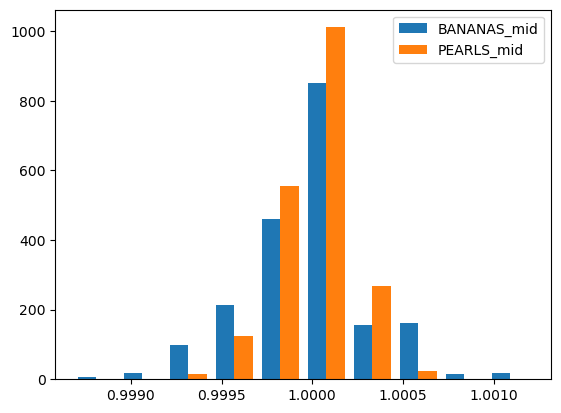

In [31]:
# distribution of price movements (pct change)
mids = ["BANANAS_mid", "PEARLS_mid"]

col = book_tops[mids]
diffs = (col.shift(-1) / col).dropna()
plt.hist(diffs, label=mids)
plt.legend()
diffs.describe().T


### Price movements (actual change)

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,1995.0,-0.008772,1.682346,-6.5,-1.0,0.0,1.0,6.0
PEARLS_mid,1995.0,0.000000,2.121911,-7.0,-1.0,0.0,1.0,7.0


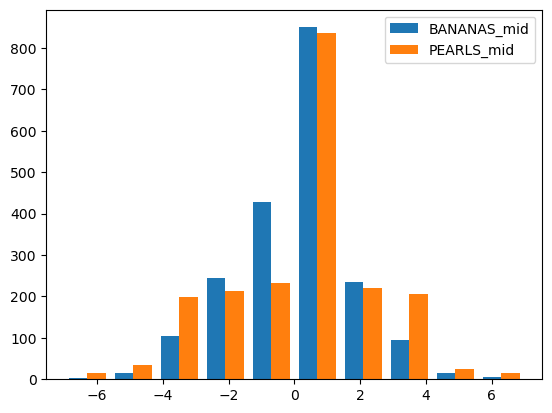

In [32]:
# distribution of price movements (actual #)
mids = ["BANANAS_mid", "PEARLS_mid"]

col = book_tops[mids]
diffs = (col.shift(-1) - col).dropna()
plt.hist(diffs, label=mids)
plt.legend()
diffs.describe().T


### Spread stats - BANANAS

In [33]:
# spread summary stats

sym = "BANANAS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1996.0,5.308116,1.898622,1.0,5.0,6.0,7.0,7.0


### Spread stats - PEARLS

In [34]:
# spread summary stats

sym = "PEARLS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1996.0,6.82014,2.466257,2.0,6.0,8.0,8.0,10.0


In [35]:
# 
trade_df.groupby("time")[["quantity"]].sum().describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,690.0,3.910145,3.823848,1.0,1.0,1.0,2.0,2.0,4.0,10.0,19.0,28.0


## Trade analysis - BANANAS

#### func - calc_rtns()

In [36]:
# find performance of trades after 1 tick, 10 ticks, 100 ticks
# returns only my trades for the specified symbol
def calc_rtns(trade_df, sym, waits):
    global fairs
    
    df = trade_df
    df = df[df["symbol"] == sym]
    df = df[df["is_me"]]
    
    # exclude trades during "closing time"
    cutoff_time = _max_time - _num_close_turns * _time_step
    df = df[df["time"] < cutoff_time]

    for wait in waits:
        suffix = f"_{wait}"

        # get shifted fairs
        fairs_shift = fairs.set_index("time").shift(-1 * wait).ffill().bfill().add_suffix(suffix)
        fairs_shift = fairs_shift.reset_index()

        df = pd.merge(df, fairs_shift)

    for wait in waits:
        df[f"rtn_{wait}"] = (df[f"{sym}_{wait}"] - df["price"]) * np.sign(df["my_quantity"])

    return df



#### func - blur()

In [37]:
def blur(df, mu=0, std=0.1):
    noise = np.random.normal(loc=mu, scale=std, size=df.shape)
    return df + noise

### Rtn over time

total prof 1445.5


,count,mean,std,min,25%,50%,75%,max
rtn_-1,323.0,1.973684,1.229839,0.0,0.50,2.0,3.0,3.5
rtn_0,323.0,0.989164,2.738733,-5.5,-1.50,1.5,3.0,7.5
rtn_1,323.0,0.913313,2.828467,-5.5,-2.00,1.5,3.0,7.5
rtn_3,323.0,1.126935,2.829962,-5.5,-1.50,2.0,3.5,8.0
rtn_10,323.0,1.009288,3.165454,-6.5,-1.75,1.5,3.5,9.0
rtn_30,323.0,1.103715,3.165848,-7.0,-1.00,1.5,3.5,9.0
rtn_100,323.0,1.286378,4.064029,-9.0,-1.50,1.0,4.0,16.5


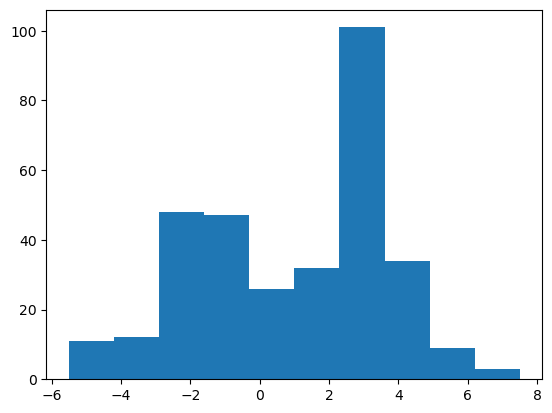

In [38]:
# summary stats for trades vs rtns

sym = "BANANAS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

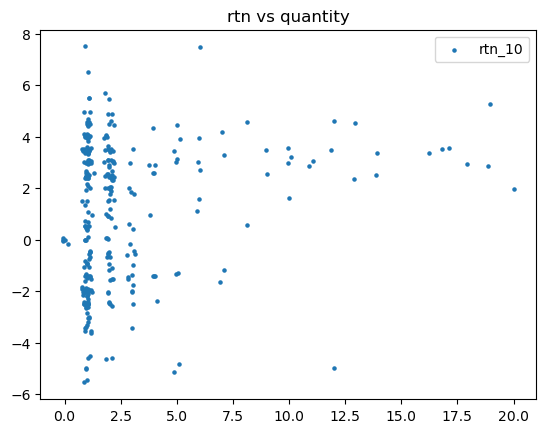

In [39]:
plt.scatter(blur(df["quantity"], std=0.1), blur(df["rtn_0"], std=0.1), s=5, label="rtn_10")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### large trades

In [40]:
# print out large trades

sizes = df.groupby("time")[["quantity"]].sum()
big_days = sizes[sizes["quantity"] >= 15]
df[df["time"].isin(big_days.index)]

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_3,rtn_10,rtn_30,rtn_100,rtn_0_total
97,SUBMISSION,4937.0,18,,BANANAS,67300,67400,671,True,True,...,4938.0,10000.0,2.5,3.0,3.5,4.0,4.0,1.0,1.0,54.0
128,,4939.0,17,SUBMISSION,BANANAS,92400,92500,922,True,False,...,4936.0,10001.5,0.5,3.5,3.5,3.5,4.5,5.0,3.0,59.5
129,SUBMISSION,4938.0,1,,BANANAS,92400,92500,922,True,True,...,4936.0,10001.5,0.5,-2.5,-2.5,-2.5,-3.5,-4.0,-2.0,-2.5
137,SUBMISSION,4932.0,17,,BANANAS,97200,97300,970,True,True,...,4931.5,10003.5,2.5,3.5,3.0,3.0,3.0,2.5,-0.5,59.5
177,SUBMISSION,4926.0,4,,BANANAS,119200,119300,1189,True,True,...,4935.0,10001.5,3.5,2.5,2.5,2.5,1.5,4.5,9.0,10.0
178,,4933.0,12,SUBMISSION,BANANAS,119200,119300,1189,True,False,...,4935.0,10001.5,3.5,4.5,4.5,4.5,5.5,2.5,-2.0,54.0
179,SUBMISSION,4926.0,0,,BANANAS,119200,119300,1189,True,True,...,4935.0,10001.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239,SUBMISSION,4929.0,19,,BANANAS,151800,151900,1515,True,True,...,4929.5,10000.0,3.0,3.0,2.5,3.0,4.0,5.0,0.5,57.0
247,,4936.0,20,SUBMISSION,BANANAS,156700,156800,1564,True,False,...,4928.5,9999.0,3.0,2.0,2.5,4.5,4.5,2.5,7.5,40.0
309,,4934.0,16,SUBMISSION,BANANAS,188600,188700,1883,True,False,...,4934.0,10001.5,3.5,3.5,2.0,3.0,2.5,1.5,-0.0,56.0


### losers: trade/book graph

In [41]:
losers = df[(df["rtn_10"] < 0)]
winners = df[df["rtn_10"] > 0]

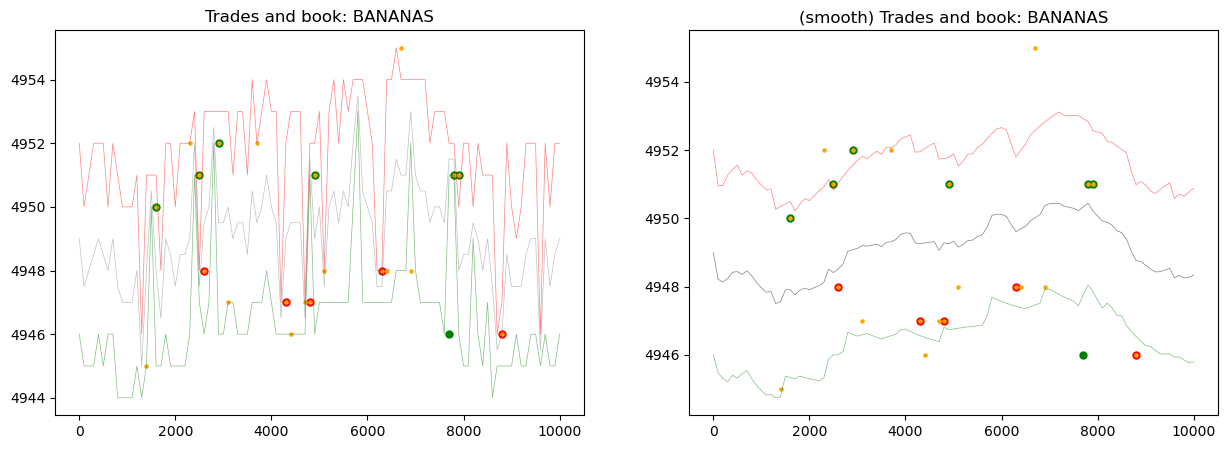

In [42]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=10000, 
    span=21,
    show_mid=True,
)


## Trade analysis - PEARLS

### rtn over time

total prof 1023.0


,count,mean,std,min,25%,50%,75%,max
rtn_-1,337.0,2.636499,1.476221,-0.0,1.0,3.0,4.0,5.0
rtn_0,337.0,1.440653,3.424923,-5.5,-2.0,2.0,4.0,8.5
rtn_1,337.0,1.537092,3.393045,-5.5,-2.0,2.0,4.0,8.0
rtn_3,337.0,1.448071,3.287938,-5.5,-2.0,2.0,4.0,8.5
rtn_10,337.0,1.462908,3.401587,-5.5,-2.0,2.0,4.0,8.5
rtn_30,337.0,1.369436,3.358870,-5.5,-2.0,2.0,4.0,8.5
rtn_100,337.0,1.443620,3.299273,-5.5,-2.0,2.0,4.0,8.0


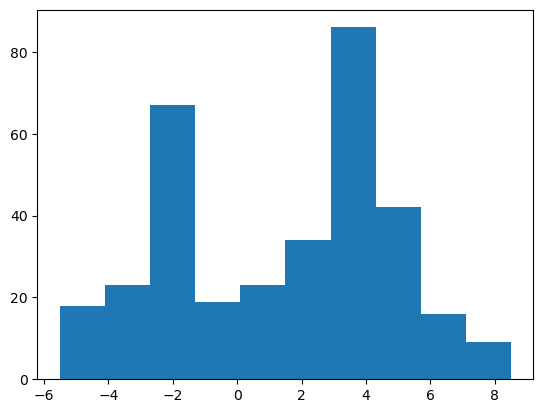

In [43]:
### summary stats for trades vs rtns

sym = "PEARLS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

### rtn vs quantity graph

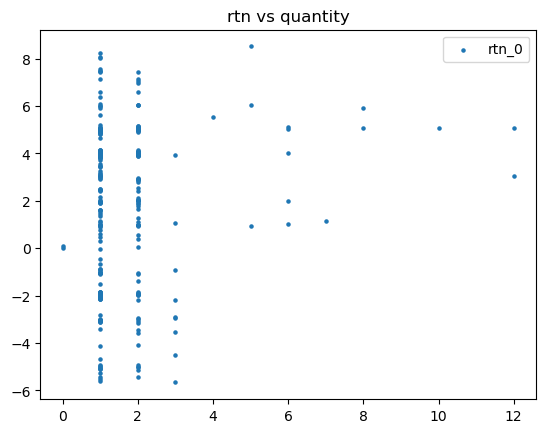

In [44]:
plt.scatter(blur(df["quantity"], std=0.0), blur(df["rtn_0"], std=0.1), s=5, label="rtn_0")
# plt.scatter(blur(df["quantity"]), blur(df["rtn_100"]), s=5, label="rtn_100")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



### losers: rtn0 vs spread

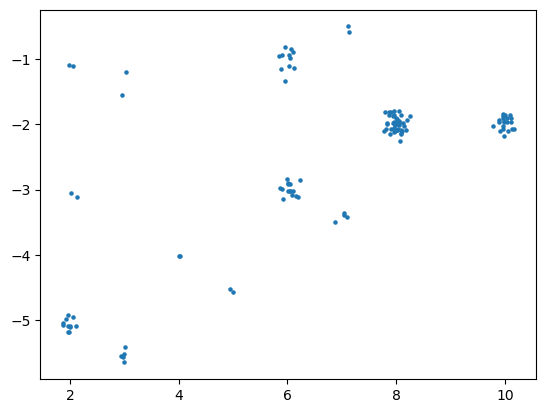

In [45]:
losers = df[(df["rtn_0"] < 0)]
winners = df[df["rtn_0"] > 0]

df = pd.merge(losers, book_tops[["PEARLS_spread", "time"]].shift(1), on="time")
plt.scatter(blur(df["PEARLS_spread"]), blur(df["rtn_0"]), s=5)

In [46]:
losers.describe().T

,count,mean,std,min,25%,50%,75%,max
price,123.0,9999.886179,2.004925,9998.0,9998.00,9998.0,10002.00,10002.0
quantity,123.0,1.292683,0.568745,1.0,1.00,1.0,1.00,3.0
order_time,123.0,98844.715447,55818.353235,300.0,50300.00,100600.0,149250.00,194200.0
time,123.0,98945.528455,55818.379739,400.0,50400.00,100800.0,149350.00,194300.0
turn,123.0,986.463415,557.011924,4.0,502.00,1004.0,1489.50,1939.0
my_quantity,123.0,-0.138211,1.410297,-3.0,-1.00,-1.0,1.00,3.0
BANANAS_-1,123.0,4938.341463,7.981874,4927.0,4932.00,4936.0,4946.25,4953.5
PEARLS_-1,123.0,9999.760163,3.157965,9996.5,9997.00,9997.0,10003.00,10003.5
BANANAS_0,123.0,4938.341463,7.916396,4927.5,4932.00,4934.5,4948.00,4953.5
PEARLS_0,123.0,10000.134146,1.466949,9996.5,10000.00,10000.0,10000.50,10003.5


### losers: histogram of price changes

(array([10.,  3., 40., 25., 12., 10.,  3.,  3.,  7., 10.]),
 array([1.5 , 2.05, 2.6 , 3.15, 3.7 , 4.25, 4.8 , 5.35, 5.9 , 6.45, 7.  ]),
 <BarContainer object of 10 artists>)

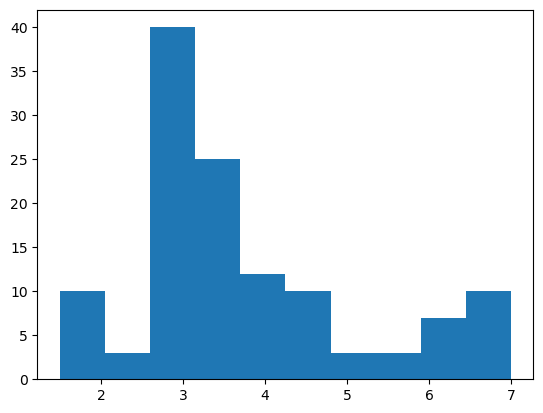

In [47]:
loser_diffs = (abs(losers["PEARLS_-1"] - losers["PEARLS_0"]))

plt.hist(loser_diffs)

### losers: trade/book graph

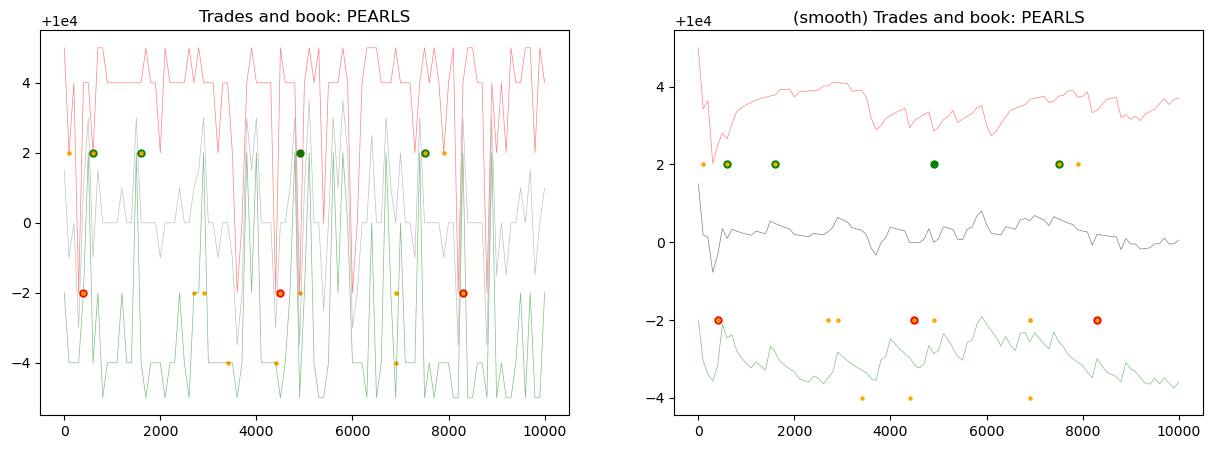

In [48]:
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=10000, 
    span=21,
    show_mid=True,
)
